In [2]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from google.cloud import storage
from datetime import datetime, timedelta

from metpy.calc import azimuth_range_to_lat_lon
from metpy.cbook import get_test_data
from metpy.io import Level3File
from metpy.plots import add_metpy_logo, add_timestamp, colortables, USCOUNTIES
from metpy.units import units

import re

# Load in BNW data table

In [41]:
file_path="C:/Users/rileybla/Desktop/CIE500_SP2025/Project/MASTER RIVERWATCH DATA_2014-2023_UB_2025-03.xlsx"

BNW=pd.read_excel(file_path, sheet_name="Master Riverkeeper Data (14-23)")
BNW.head()


,key,station_id_old,station_id_new,station_name,River,collection_date,Conductivity [p:2928],Dissolved Oxygen % [p:2925],Dissolved Oxygen (mg/L) [p:2924],E. coli [p:2927],...,owner_first_name,owner_last_name,certified,certifier_id,certifier_first_name,certifier_last_name,dataset_id,dataset_name,dataset_key,Buffalo_Y_N
0,NaN,BC04,BC01,Beaver Meadow Pond,Buffalo Creek,2017-05-20 10:01:00,100.3,84.0,8.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,BC04,BC01,Beaver Meadow Pond,Buffalo Creek,2017-06-17 10:54:23,163.6,140.8,11.34,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,BC04,BC01,Beaver Meadow Pond,Buffalo Creek,2017-07-15 10:42:26,133.6,101.0,8.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,BC04,BC01,Beaver Meadow Pond,Buffalo Creek,2017-08-19 10:57:00,144.5,61.5,5.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,BC04,BC01,Beaver Meadow Pond,Buffalo Creek,2017-09-16 10:46:07,132.8,96.9,8.74,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# collect dates, locations, data measurements
 # Extract specific columns from the DataFrame
BNW_sub= BNW[["collection_date", "Conductivity [p:2928]","Dissolved Oxygen % [p:2925]","Dissolved Oxygen (mg/L) [p:2924]","E. coli [p:2927]","Temperature [p:2926]", "Total Dissolved Solids [p:2921]","Turbidity [p:2922]", "latitude","longitude"]]

# Show the result
BNW_sub.head()


,collection_date,Conductivity [p:2928],Dissolved Oxygen % [p:2925],Dissolved Oxygen (mg/L) [p:2924],E. coli [p:2927],Temperature [p:2926],Total Dissolved Solids [p:2921],Turbidity [p:2922],latitude,longitude
0,2017-05-20 10:01:00,100.3,84.0,8.14,NaN,16.9,77.4,3.69,42.672292,-78.38243
1,2017-06-17 10:54:23,163.6,140.8,11.34,NaN,26.4,103.3,1.71,42.672292,-78.38243
2,2017-07-15 10:42:26,133.6,101.0,8.47,NaN,24.2,88.4,8.49,42.672292,-78.38243
3,2017-08-19 10:57:00,144.5,61.5,5.20,NaN,23.7,96.2,3.04,42.672292,-78.38243
4,2017-09-16 10:46:07,132.8,96.9,8.74,NaN,20.4,94.9,2.64,42.672292,-78.38243


In [ ]:
# Split collection_date into 3 sections
BNW_sub["collection_date"]

years = []
months = []
days = []
times = []

# Loop through the 'collection date' column
for date_str in BNW_sub['collection_date']:
    # Convert the string to a datetime object if needed
    #dt_object = datetime.strptime(date_str, "%Y-%m-%d %H:%M:%S")
    
    # Extract the year, month, day, and time components
    year = date_str.year
    month = f"{date_str.month:02d}"  # Format month to be two digits
    day = f"{date_str.day:02d}"      # Format day to be two digits
    time_str = date_str.strftime("%H%M%S")
    
    # Append the extracted values to the respective lists
    years.append(year)
    months.append(month)
    days.append(day)
    times.append(time_str)

# Add these as new columns in the DataFrame
BNW_sub['Year'] = years
BNW_sub['Month'] = months
BNW_sub['Day'] = days
BNW_sub['Time'] = times

# Show the updated DataFrame
BNW_sub


# Save the table to your folder
BNW_sub.to_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx', index=False)

NameError: name 'BNW_sub' is not defined

# Download Data from Google repository

In [6]:
# Only Download data for the desired date/times
# Downloading data from:  https://console.cloud.google.com/storage/browser/gcp-public-data-nexrad-l3;tab=objects?invt=AbuECA&prefix=&forceOnObjectsSortingFiltering=false
# Simulated BNW_sub DataFrame (replace this with your actual DataFrame)
BNW_sub = pd.read_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx')
# Suppose your Excel file has a column 'collection_date' with combined date and time
BNW_sub['collection_date'] = pd.to_datetime(BNW_sub['collection_date'])

# Extract year, month, day, and time as strings (with leading zeros)
BNW_sub['Year'] = BNW_sub['collection_date'].dt.strftime('%Y')
BNW_sub['Month'] = BNW_sub['collection_date'].dt.strftime('%m')
BNW_sub['Day'] = BNW_sub['collection_date'].dt.strftime('%d')
BNW_sub['Time'] = BNW_sub['collection_date'].dt.strftime('%H%M%S')

#BNW_sub =pd.DataFrame({
#    'collection_date': pd.to_datetime(['2024-07-01 12:00:00', '2025-01-02 13:30:00', '2025-04-01 15:45:00']),
#    'Year': [2024, 2025, 2025],
#    'Month': ['07', '01', '04'],
#    'Day': ['01', '02', '01'],
#    'Time': ['120000', '133000', '154500']
#})

# Define the function to download public files
def download_public_file(bucket_name, source_blob_name, destination_file_name):
    """Downloads a public blob from the bucket."""
    storage_client = storage.Client.create_anonymous_client()

    # Get the bucket and blob
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    # Download the file to the specified destination
    blob.download_to_filename(destination_file_name)

    print(f"Downloaded public blob {source_blob_name} from bucket {bucket_name} to {destination_file_name}.")

# Parameters for downloading
bucket_name = "gcp-public-data-nexrad-l3"

# Create an empty list to store the file names
file_names = []

# Loop through each row in BNW_sub to construct and download files
for _, row in BNW_sub.iterrows():
    year = row['Year']
    month = row['Month']
    day = row['Day']
    time= row['Time']
    
    # Construct source_blob_name dynamically based on table data
    source_blob_name = f"{year}/{month}/{day}/KBUF/NWS_NEXRAD_NXL3_KBUF_{year}{month}{day}000000_{year}{month}{day}235959.tar.gz"
    
    # Construct destination file name dynamically #keep list of all filenames
    destination_file_name = f"KBUF_{year}{month}{day}.tar.gz"

    # Call the download function
    download_public_file(bucket_name, source_blob_name, destination_file_name)

     # Append the file name to the list
    file_names.append(destination_file_name)

# Add the file names as a new column to the BNW_sub DataFrame
BNW_sub['file_name'] = file_names

print(BNW_sub)


Downloaded public blob 2017/05/20/KBUF/NWS_NEXRAD_NXL3_KBUF_20170520000000_20170520235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20170520.tar.gz.
Downloaded public blob 2017/06/17/KBUF/NWS_NEXRAD_NXL3_KBUF_20170617000000_20170617235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20170617.tar.gz.
Downloaded public blob 2017/07/15/KBUF/NWS_NEXRAD_NXL3_KBUF_20170715000000_20170715235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20170715.tar.gz.
Downloaded public blob 2017/08/19/KBUF/NWS_NEXRAD_NXL3_KBUF_20170819000000_20170819235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20170819.tar.gz.
Downloaded public blob 2017/09/16/KBUF/NWS_NEXRAD_NXL3_KBUF_20170916000000_20170916235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20170916.tar.gz.
Downloaded public blob 2017/10/21/KBUF/NWS_NEXRAD_NXL3_KBUF_20171021000000_20171021235959.tar.gz from bucket gcp-public-data-nexrad-l3 to KBUF_20171021.tar.gz.
Downloaded public blob 2017/11/18/KBUF/N

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/gcp-public-data-nexrad-l3/o/2018%2F09%2F08%2FKBUF%2FNWS_NEXRAD_NXL3_KBUF_20180908000000_20180908235959.tar.gz?alt=media: No such object: gcp-public-data-nexrad-l3/2018/09/08/KBUF/NWS_NEXRAD_NXL3_KBUF_20180908000000_20180908235959.tar.gz: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)

In [8]:
import pandas as pd
from google.cloud import storage
from google.api_core import exceptions
import os

# Read your Excel file
BNW_sub = pd.read_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx')

# Convert 'collection_date' to datetime objects
BNW_sub['collection_date'] = pd.to_datetime(BNW_sub['collection_date'])

# Extract year, month, day, and time as strings
BNW_sub['Year'] = BNW_sub['collection_date'].dt.strftime('%Y')
BNW_sub['Month'] = BNW_sub['collection_date'].dt.strftime('%m')
BNW_sub['Day'] = BNW_sub['collection_date'].dt.strftime('%d')
BNW_sub['Time'] = BNW_sub['collection_date'].dt.strftime('%H%M%S')

# Define the function to download public files
def download_public_file(bucket_name, source_blob_name, destination_file_name):
    """Downloads a public blob from the bucket, skipping if the file already exists."""
    # Check if the file already exists locally
    if os.path.exists(destination_file_name):
        print(f"File {destination_file_name} already exists. Skipping download.")
        return True  # Indicate that the file "exists"

    storage_client = storage.Client.create_anonymous_client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    try:
        # Download the file to the specified destination
        blob.download_to_filename(destination_file_name)
        print(f"Downloaded public blob {source_blob_name} from bucket {bucket_name} to {destination_file_name}.")
        return True  # Indicate success
    except exceptions.NotFound:
        print(f"File {source_blob_name} not found in bucket {bucket_name}. Skipping.")
        return False  # Indicate failure
    except Exception as e:
        print(f"An error occurred while downloading {source_blob_name}: {e}")
        return False  # Indicate failure

# Parameters for downloading
bucket_name = "gcp-public-data-nexrad-l3"

# Create an empty list to store the file names
file_names = []

# Loop through each row in BNW_sub to construct and download files
for _, row in BNW_sub.iterrows():
    year = row['Year']
    month = row['Month']
    day = row['Day']
    time= row['Time']
    
    # Construct source_blob_name dynamically based on table data
    source_blob_name = f"{year}/{month}/{day}/KBUF/NWS_NEXRAD_NXL3_KBUF_{year}{month}{day}000000_{year}{month}{day}235959.tar.gz"
    
    # Construct destination file name dynamically #keep list of all filenames
    destination_file_name = f"KBUF_{year}{month}{day}.tar.gz"

    # Call the download function
    if download_public_file(bucket_name, source_blob_name, destination_file_name):
         # Append the file name to the list if download was successful
        file_names.append(destination_file_name)
    else:
        file_names.append(None)  # Append None if download failed

# Add the file names as a new column to the BNW_sub DataFrame
BNW_sub['file_name'] = file_names

print(BNW_sub)



File KBUF_20170520.tar.gz already exists. Skipping download.
File KBUF_20170617.tar.gz already exists. Skipping download.
File KBUF_20170715.tar.gz already exists. Skipping download.
File KBUF_20170819.tar.gz already exists. Skipping download.
File KBUF_20170916.tar.gz already exists. Skipping download.
File KBUF_20171021.tar.gz already exists. Skipping download.
File KBUF_20171118.tar.gz already exists. Skipping download.
File KBUF_20180512.tar.gz already exists. Skipping download.
File KBUF_20180609.tar.gz already exists. Skipping download.
File KBUF_20180714.tar.gz already exists. Skipping download.
File KBUF_20180811.tar.gz already exists. Skipping download.
File 2018/09/08/KBUF/NWS_NEXRAD_NXL3_KBUF_20180908000000_20180908235959.tar.gz not found in bucket gcp-public-data-nexrad-l3. Skipping.
File KBUF_20181013.tar.gz already exists. Skipping download.
File KBUF_20190518.tar.gz already exists. Skipping download.
File KBUF_20190615.tar.gz already exists. Skipping download.
File KBUF_

In [9]:
# Save the table to your folder
BNW_sub.to_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx', index=False)

In [ ]:
import tarfile
import os
import pandas as pd

#extract from each .tar file the radar products specified, save them to a new folder

extraction_dir = 'extracted_files'
os.makedirs(extraction_dir, exist_ok=True)
radar_products = ['N1P', 'NTP', 'DAA', 'DUA', 'STA', 'DSA', 'OHA']

def extract_tar_gz(file_name, extraction_dir, radar_products):
    if not isinstance(file_name, str):
        print(f"Skipping: Invalid filename {file_name} (not a string).")
        return []

    if file_name == 'nan' or not file_name:
        print(f"Skipping: No filename provided.")
        return []

    if not os.path.exists(file_name):
        print(f"Skipping: {file_name} does not exist.")
        return []

    if os.path.getsize(file_name) < 100:
        print(f"Skipping: {file_name} is empty or too small.")
        os.remove(file_name)
        return []

    try:
        with tarfile.open(file_name, 'r:gz') as tar:
            extracted_extensions = set()
            for member in tar.getmembers():
                if any(pattern in member.name for pattern in radar_products):
                    extracted_path = os.path.join(extraction_dir, member.name)
                    if os.path.exists(extracted_path):
                        print(f"Skipping: {member.name} already exists.")
                    else:
                        print(f"Extracting: {member.name}")
                        tar.extract(member, path=extraction_dir)
                        _, ext = os.path.splitext(member.name)
                        extracted_extensions.add(ext.lower())
            return list(extracted_extensions)
    except (tarfile.ReadError, EOFError) as e:
        print(f"Corrupt or incomplete tar file: {file_name} ({e}). Removing.")
        os.remove(file_name)
        return []

# Example DataFrame loading
BNW_sub = pd.read_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx')
BNW_sub['file_name'] = BNW_sub['file_name'].astype(str) #Convert to string
BNW_sub['extracted_extensions'] = None

for index, row in BNW_sub.iterrows():
    file_name = row['file_name']
    extensions = extract_tar_gz(file_name, extraction_dir, radar_products)
    BNW_sub.at[index, 'extracted_extensions'] = ', '.join(extensions) if extensions else ''

print(BNW_sub[['file_name', 'extracted_extensions']].head())




In [ ]:
# using each row in:
# Read your Excel file
#BNW_sub = pd.read_excel('C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx')

# find the file with the closest time to the time column write the name of the file in a new column. if the file is a UAA product store to UAA column etc

import pandas as pd
import os
import re
from datetime import datetime, timedelta

# Excel file
excel_file = 'C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx'

# Local directory to search
local_dir = "C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files"

# Load data
BNW_sub = pd.read_excel(excel_file)

# Get first row
target_row = BNW_sub.iloc[0].copy()

# Extract date and time components from the DataFrame
year = target_row['Year']
month = target_row['Month']
day = target_row['Day']
time_str = str(target_row['Time'])
time_str = time_str.zfill(6)  # Ensure it's 6 digits (HHMMSS)

# Create datetime object from components
target_datetime = datetime(year, month, day, int(time_str[:2]), int(time_str[2:4]), int(time_str[4:6]))

# Function to parse filenames
def parse_filename(filename):
    match = re.search(r'KBUF_SDUS\d{2}_([A-Z]{3,4})BUF_(\d{8})(\d{4})', filename)
    if match:
        product, date, time = match.groups()
        file_datetime = datetime.strptime(f"{date}{time}", "%Y%m%d%H%M")
        return product, file_datetime
    return None, None

# Find closest file
closest_file = None
min_diff = timedelta.max

# List local files
local_files = [f for f in os.listdir(local_dir) if os.path.isfile(os.path.join(local_dir, f))]

for filename in local_files:
    # Parse filename
    product, file_datetime = parse_filename(filename)

    if product and file_datetime:
        time_diff = abs(file_datetime - target_datetime)

        if time_diff < min_diff:
            min_diff = time_diff
            closest_file = filename

# Store result in row
if closest_file:
    product = closest_file.split('_')[2][:3] #Get product from filename
    target_row[product] = closest_file
    print(f"Closest file found: {closest_file} in {local_dir}")
else:
    print(f"No matching files found in {local_dir}")

# Print results
print(target_row)



Closest file found: KBUF_SDUS51_NTPBUF_201705201001 in C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files
collection_date                                 2017-05-20 10:01:00
Conductivity [p:2928]                                         100.3
Dissolved Oxygen % [p:2925]                                    84.0
Dissolved Oxygen (mg/L) [p:2924]                               8.14
E. coli [p:2927]                                                NaN
Temperature [p:2926]                                           16.9
Total Dissolved Solids [p:2921]                                77.4
Turbidity [p:2922]                                             3.69
latitude                                                  42.672292
longitude                                                 -78.38243
Year                                                           2017
Month                                                             5
Day                                                              

In [9]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta

# Configuration
excel_file = 'C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx'
local_dir = "C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files"
output_file = 'C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_with_products.xlsx'

# Load data
BNW_sub = pd.read_excel(excel_file)

# Initialize product columns
products = ['N1P', 'NTP', 'DAA', 'DUA', 'STA', 'DSA', 'OHA']  # Add/remove based on your actual products
for product in products:
    if product not in BNW_sub.columns:
        BNW_sub[product] = None

# File parsing function
def parse_filename(filename):
    match = re.search(r'KBUF_SDUS\d{2}_([A-Z]{3,4})BUF_(\d{8})(\d{4})', filename)
    if match:
        product, date, time = match.groups()
        file_datetime = datetime.strptime(f"{date}{time}", "%Y%m%d%H%M")
        return product, file_datetime
    return None, None

# Process all rows
for index, row in BNW_sub.iterrows():
    # Create datetime from components
    try:
        time_str = str(int(row['Time'])).zfill(6)
        target_dt = datetime(row['Year'], row['Month'], row['Day'],
                            int(time_str[:2]), int(time_str[2:4]), int(time_str[4:6]))
        
        # Search for closest file
        closest_file = None
        min_diff = timedelta.max
        
        for filename in os.listdir(local_dir):
            product, file_dt = parse_filename(filename)
            if file_dt:
                time_diff = abs(file_dt - target_dt)
                
                if time_diff < min_diff:
                    min_diff = time_diff
                    closest_file = (filename, product)
        
        # Update columns
        if closest_file:
            filename, product = closest_file
            if product in BNW_sub.columns:
                BNW_sub.at[index, product] = filename
            else:
                print(f"Unrecognized product {product} in {filename}")
                
    except Exception as e:
        print(f"Error processing row {index}: {str(e)}")

# Save results
BNW_sub.to_excel(output_file, index=False)
print(f"Results saved to {output_file}")


Results saved to C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_with_products.xlsx


In [ ]:
#pull files within time buffer to specified time
import pandas as pd
import os
import re
from datetime import datetime, timedelta

# Excel file
excel_file = 'C:/Users/rileybla/Desktop/CIE500_SP2025/Project/BNW_sub_updated.xlsx'

# Local directory to search
local_dir = "C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files"

# Load data
BNW_sub = pd.read_excel(excel_file)

# Get first row
target_row = BNW_sub.iloc[0].copy()

# Extract date and time components from the DataFrame
year = target_row['Year']
month = target_row['Month']
day = target_row['Day']
time_str = str(target_row['Time'])
time_str = time_str.zfill(6)  # Ensure it's 6 digits (HHMMSS)

# Create datetime object from components
target_datetime = datetime(year, month, day, int(time_str[:2]), int(time_str[2:4]), int(time_str[4:6]))

# Set time buffer
time_buffer = timedelta(hours=1)

# Function to parse filenames
def parse_filename(filename):
    match = re.search(r'KBUF_SDUS\d{2}_([A-Z]{3,4})BUF_(\d{8})(\d{4})', filename)
    if match:
        product, date, time = match.groups()
        file_datetime = datetime.strptime(f"{date}{time}", "%Y%m%d%H%M")
        return product, file_datetime
    return None, None

# Find files within time buffer
matching_files = []

# List local files
local_files = [f for f in os.listdir(local_dir) if os.path.isfile(os.path.join(local_dir, f))]

for filename in local_files:
    # Parse filename
    product, file_datetime = parse_filename(filename)

    if product and file_datetime:
        time_diff = abs(file_datetime - target_datetime)

        if time_diff <= time_buffer:
            matching_files.append((filename, product))

# Store result in row
if matching_files:
    print(f"Files found within the time buffer in {local_dir}:")
    for filename, product in matching_files:
        target_row[product] = filename  # Store filename in product column
        print(f"  - {filename} (Product: {product})")
else:
    print(f"No matching files found within the time buffer in {local_dir}")

# Print results
print(target_row)


Files found within the time buffer in C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files:
  - KBUF_SDUS51_NTPBUF_201705200904 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200907 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200911 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200915 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200918 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200922 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200926 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200929 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200933 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200936 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200940 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200944 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200947 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200951 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200954 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705200958 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_201705201001 (Product: NTP)
  - KBUF_SDUS51_NTPBUF_2017052

# How to download One file given a specified link

def download_public_file(bucket_name, source_blob_name, destination_file_name):
    """Downloads a public blob from the bucket."""
    # Create an anonymous client since the bucket is public
    storage_client = storage.Client.create_anonymous_client()

    # Get the bucket and blob
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)

    # Download the file to the specified destination
    blob.download_to_filename(destination_file_name)

    print(
        f"Downloaded public blob {source_blob_name} from bucket {bucket_name} to {destination_file_name}."
    )

# figure out how to loop/ batch download...maybe use based on the table BNW data
# Parameters for downloading
bucket_name = "gcp-public-data-nexrad-l3"
source_blob_name = "2010/07/05/KBUF/NWS_NEXRAD_NXL3_KBUF_20100705000000_20100705235959.tar.Z"  # Replace with actual filename
destination_file_name = "KBUF_20100705.tar.Z"  # Local path to save file

# Run the download function
download_public_file(bucket_name, source_blob_name, destination_file_name)


# NEXRAD Level 3 File

Use MetPy to read information from a NEXRAD Level 3 (NIDS product) file and plot


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


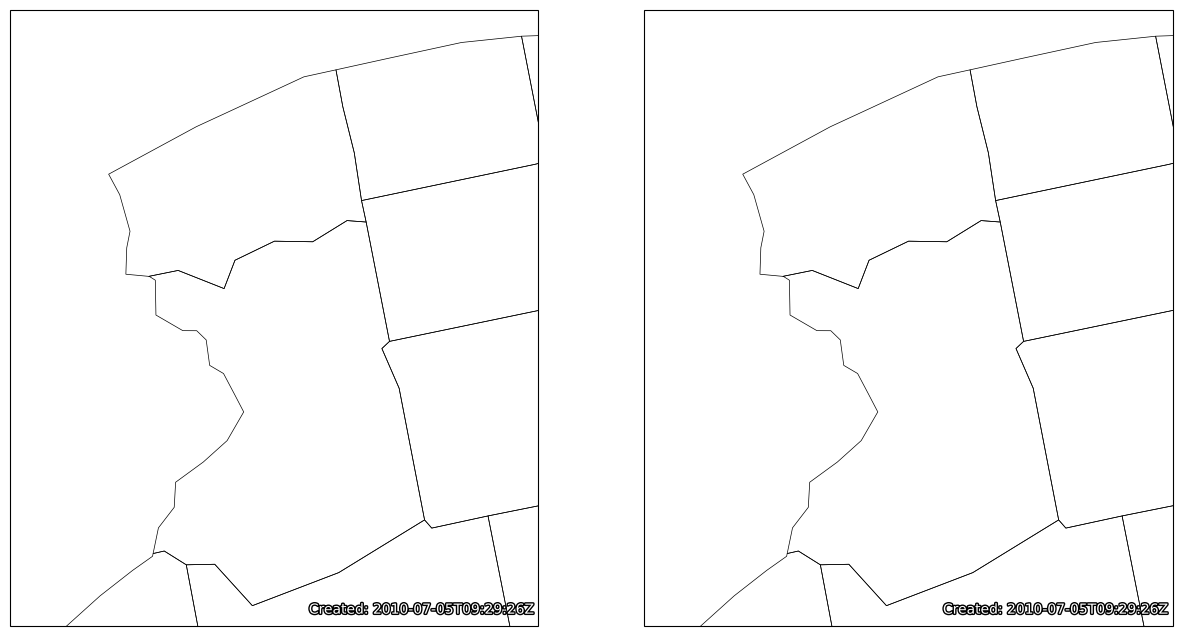

In [92]:
spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 8))
#add_metpy_logo(fig, 190, 85, size='large')
ctables = (('NWSStormClearReflectivity', -20, 0.5),  # dBZ
           ('NWS8bitVel', -100, 1.0))  # m/s


for v, ctable, ax_rect in zip(('N0Q', 'N1P'), ctables, spec):  #N0Q, N0U #add destination_file_name to loop
    # Open the file
    #name = get_test_data(f'nids/KOUN_SDUS54_{v}TLX_201305202016', as_file_obj=False)
    name = "C:/Users/rileybla/Desktop/KBUF_SDUS31_N1PBUF_201007050924"  #needs to be for specific time e.g.KBUF_SDUS21_N1QBUF_201007050002
    f = Level3File(name)

    # Pull the data out of the file object
    datadict = f.sym_block[0][0]

    # Turn into an array using the scale specified by the file
    data = f.map_data(datadict['data'])

    # Grab azimuths and calculate a range based on number of gates,
    # both with their respective units
    az = units.Quantity(np.array(datadict['start_az'] + [datadict['end_az'][-1]]), 'degrees')
    rng = units.Quantity(np.linspace(0, f.max_range, data.shape[-1] + 1), 'kilometers')

    # Extract central latitude and longitude from the file
    cent_lon = f.lon
    cent_lat = f.lat

    # Convert az,range to x,y
    xlocs, ylocs = azimuth_range_to_lat_lon(az, rng, cent_lon, cent_lat)

    # Plot the data
    crs = ccrs.LambertConformal()
    ax = fig.add_subplot(ax_rect, projection=crs)
    ax.add_feature(USCOUNTIES, linewidth=0.5)
    norm, cmap = colortables.get_with_steps(*ctable)
    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
    ax.set_extent([cent_lon - 0.5, cent_lon + 0.5, cent_lat - 0.5, cent_lat + 0.5])
    ax.set_aspect('equal', 'datalim')
    add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)

    # add legend of rain depth

plt.show()

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from metpy.io import Level3File
from metpy.units import units
from metpy.calc import azimuth_range_to_lat_lon
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os

# collect precipitation at each specified point and time
# Read the Excel file
df = pd.read_excel("BNW_sub_with_products.xlsx")

# Add new column for precipitation if it doesn't exist
if 'precip in' not in df.columns:
    df['precip in'] = np.nan

# Base path for the radar files (adjust if needed)
base_path = "C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/"

# Loop through each row in the dataframe
for index, row in df.iterrows():
    try:
        # Extract target latitude and longitude from the row
        target_lat = row['latitude']
        target_lon = row['longitude']
        
        # Get the file name from the appropriate column
        ntp_file = row['NTP']
        
        if pd.isna(ntp_file) or not ntp_file:
            print(f"Row {index}: Missing NTP file, skipping.")
            continue
        
        # Construct the full file path
        file_path = os.path.join(base_path, ntp_file)
        
        print(f"Processing row {index}, file: {file_path}")
        
        # Open the radar file
        f = Level3File(file_path)

        # Extract data from the radar file
        datadict = f.sym_block[0][0]
        data = f.map_data(datadict['data'])

        # Calculate azimuths and ranges
        az = units.Quantity(np.array(datadict['start_az'] + [datadict['end_az'][-1]]), 'degrees')
        rng = units.Quantity(np.linspace(0, f.max_range, data.shape[-1] + 1), 'kilometers')

        # Convert azimuth and range to latitude/longitude grid
        cent_lon = f.lon
        cent_lat = f.lat
        xlocs, ylocs = azimuth_range_to_lat_lon(az, rng, cent_lon, cent_lat)

        # Find the nearest grid point to the target location
        distance = np.sqrt((xlocs - target_lon)**2 + (ylocs - target_lat)**2)
        nearest_index = np.unravel_index(np.argmin(distance), distance.shape)
        nearest_value = data[nearest_index]

        print(f"Row {index}: Precipitation at ({target_lat}, {target_lon}): {nearest_value}")
        
        # Save precipitation value to the dataframe
        df.at[index, 'precip in'] = nearest_value
        
    except Exception as e:
        print(f"Error processing row {index}: {e}")
        continue

# Save the updated dataframe back to the Excel file
df.to_excel("BNW_sub_with_products.xlsx", index=False)

print("Processing complete. Precipitation values have been saved to 'precip in' column.")


Processing row 0, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201705201001
Row 0: Precipitation at (42.672292, -78.38243): nan
Processing row 1, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201706171053
Row 1: Precipitation at (42.672292, -78.38243): 1.0
Processing row 2, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201707131000
Row 2: Precipitation at (42.672292, -78.38243): 0.30000000000000004
Processing row 3, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201708191056
Row 3: Precipitation at (42.672292, -78.38243): nan
Processing row 4, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201709161047
Row 4: Precipitation at (42.672292, -78.38243): nan
Processing row 5, file: C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201710211046
Row 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Nearest value at (42.672292, -78.38243): 0.30000000000000004
Nearest value at (42.672292, -78.38243): 0.30000000000000004


c:\Users\rileybla\Desktop\CIE500_SP2025\.venv\Lib\site-packages\cartopy\mpl\geoaxes.py:524: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  return super().draw(renderer=renderer, **kwargs)


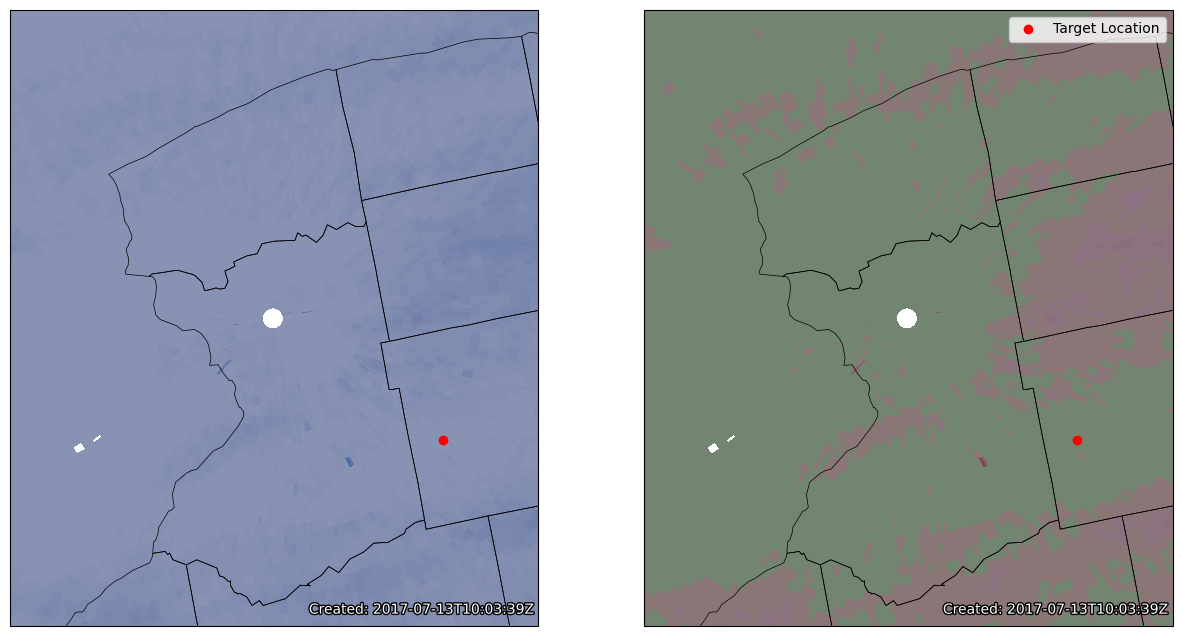

In [17]:
# to pull data for specific points with an image visualizaion, manual file and lat lon input
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from metpy.plots import add_timestamp, colortables
from metpy.io import Level3File
from metpy.units import units
from metpy.calc import azimuth_range_to_lat_lon
import cartopy.crs as ccrs
import numpy as np


# Define target location (latitude and longitude)
#update to read from table in loop fashion
target_lat =42.672292

target_lon = -78.38243


# Create figure and grid layout
spec = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(15, 8))

# Define color tables and value ranges for each product type
ctables = (
    ('NWSStormClearReflectivity', -20, 0.5),  # dBZ for N0Q (example)
    ('NWS8bitVel', -100, 1.0)                # m/s for N1P (example)
)

# Loop through radar products (e.g., N0Q, N1P)
for v, ctable, ax_rect in zip(('NTP'), ctables, spec):
    # Open the radar file for the date associated with the same row and lat lon data
    name = "C:/Users/rileybla/Desktop/CIE500_SP2025/Project/extracted_files/KBUF_SDUS51_NTPBUF_201707131000"  # Replace with actual file path
    f = Level3File(name)

    # Extract data from the radar file
    datadict = f.sym_block[0][0]
    data = f.map_data(datadict['data'])

    # Calculate azimuths and ranges
    az = units.Quantity(np.array(datadict['start_az'] + [datadict['end_az'][-1]]), 'degrees')
    rng = units.Quantity(np.linspace(0, f.max_range, data.shape[-1] + 1), 'kilometers')

    # Convert azimuth and range to latitude/longitude grid
    cent_lon = f.lon
    cent_lat = f.lat
    xlocs, ylocs = azimuth_range_to_lat_lon(az, rng, cent_lon, cent_lat)

    # Find the nearest grid point to the target location
    distance = np.sqrt((xlocs - target_lon)**2 + (ylocs - target_lat)**2)
    nearest_index = np.unravel_index(np.argmin(distance), distance.shape)
    nearest_value = data[nearest_index]

    print(f"Nearest value at ({target_lat}, {target_lon}): {nearest_value}")

    # Plot the radar data on a map
    crs = ccrs.LambertConformal()
    ax = fig.add_subplot(ax_rect, projection=crs)
    ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.5)
    
    norm, cmap = colortables.get_with_steps(*ctable)
    ax.pcolormesh(xlocs, ylocs, data, norm=norm, cmap=cmap, transform=ccrs.PlateCarree())
    
    # Highlight the target location on the map
    ax.plot(target_lon, target_lat, 'ro', transform=ccrs.PlateCarree(), label='Target Location')
    
    ax.set_extent([cent_lon - 0.5, cent_lon + 0.5, cent_lat - 0.5, cent_lat + 0.5])
    ax.set_aspect('equal', 'datalim')
    
    add_timestamp(ax, f.metadata['prod_time'], y=0.02, high_contrast=True)

plt.legend()
plt.show()
# Save point value to new column in excel table " 1hr Precip"
